# Computer Vision - HW 3

<b>Group Number:</b> 10

<b>Group Members:</b>

Rana Elfakharany    - g00087725

Hiba Saleem         - g00087239

## Dataset Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split

import os
import tempfile
from PIL import Image

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from ray import tune, train
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

from functools import partial

# TODO: Migrate to ray.train.Checkpoint and remove following line
os.environ["RAY_AIR_NEW_PERSISTENCE_MODE"]="0"

In [2]:
# Creating a Custom Dataset class to load the given dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = CustomDataset(root_dir=r'C:\Users\ronyf\OneDrive - aus.edu\Desktop\Dataset', transform=transform)

In [3]:
# Splitting the data into 60-20-20 for training, validation, and testing
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating the data loaders
batchSize = 64
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

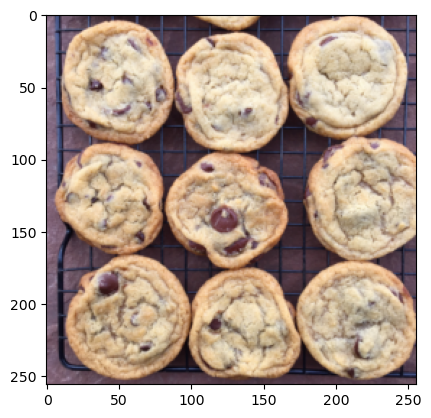

In [4]:
# Testing to check one image
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), transforms.ToPILImage()])

plt.imshow(transform_back(train_dataset.dataset[40][0]));

In [6]:
dataset.class_to_idx

{'Cookie': 0, 'Dimsum': 1, 'Sushi': 2}

## Question 1: Dense

### Building the Model

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(3*256*256, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 8, bias=True),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = torch.flatten(x,1)
        x = self.network(x)
        return x

In [68]:
model1 = DenseModel()
model1 = model1.to(device)
print(model1)

DenseModel(
  (network): Sequential(
    (0): Linear(in_features=196608, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


### Training the Model

In [69]:
criteria = nn.NLLLoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
train_history = []                                         
validation_history = []

# Training Loop
model1.train()                                              
                                                            
for epoch in range(10):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(inputs.shape[0], -1)

        optimizer.zero_grad()
        outputs = model1(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model1(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')

c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.02261258714728885 | Validation Loss: 0.01880891889333725
Epoch [2] --> Training Loss: 0.015441045496198865 | Validation Loss: 0.018127744495868684
Epoch [3] --> Training Loss: 0.013543633984194862 | Validation Loss: 0.017413387993971508
Epoch [4] --> Training Loss: 0.012045540279812283 | Validation Loss: 0.01786343942085902
Epoch [5] --> Training Loss: 0.011706039044592116 | Validation Loss: 0.01803124099969864
Epoch [6] --> Training Loss: 0.010212210648589664 | Validation Loss: 0.018337240914503734
Epoch [7] --> Training Loss: 0.009680481536520852 | Validation Loss: 0.018207899630069732
Epoch [8] --> Training Loss: 0.00986529173122512 | Validation Loss: 0.018221266170342764
Epoch [9] --> Training Loss: 0.008603279408481386 | Validation Loss: 0.019883362154165904
Epoch [10] --> Training Loss: 0.007654387851556142 | Validation Loss: 0.0217916202545166

Finished Training


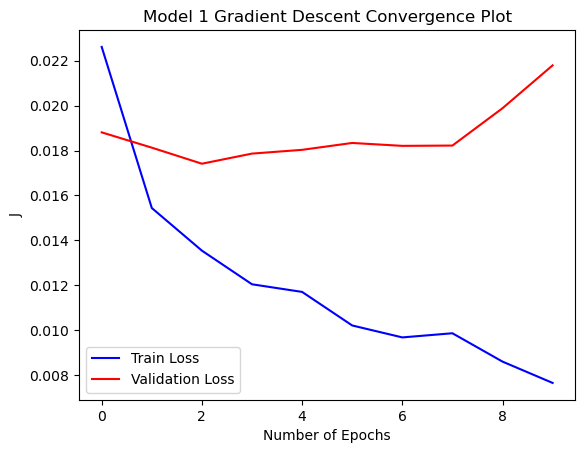

In [70]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 1 Gradient Descent Convergence Plot')
plt.show()

### Model Performance

Actual: Sushi 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Dimsum


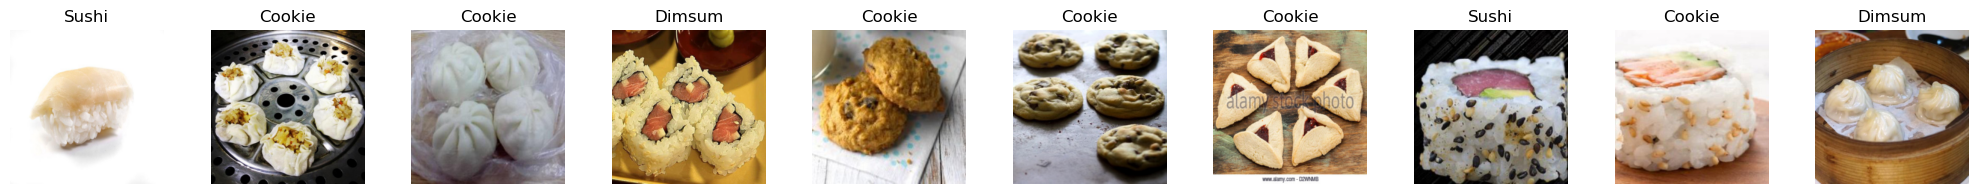

In [71]:
images, labels = next(iter(test_loader))              
images = images.to(device)
labels = labels.to(device)

outputs = model1(images)
_, predicted = torch.max(outputs, dim = 1)                

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [72]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

print('Results of Model 1 on the Test Images: ')        
print(f'Accuracy: {100 * correct / total}%')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1} \n")
print(classification_report(labels.cpu(), predicted.cpu()))

Results of Model 1 on the Test Images: 
Accuracy: 60.666666666666664%
Precision: 0.38383838383838387
Recall: 0.5476190476190476
F1-score: 0.40666666666666673 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.82      0.64      0.72        14
           2       0.33      1.00      0.50         4

    accuracy                           0.54        24
   macro avg       0.38      0.55      0.41        24
weighted avg       0.53      0.54      0.50        24



### Hyperparameter Tuning with Ray Tune

The parameters we chose to tune are:
- Number of neurons in each layer
- Batch size of the images
- Learning rate 

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DenseTune(nn.Module):
    def __init__(self, l1=64, l2=32, l3=16):
        super(DenseTune, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(3*256*256, l1, bias=True),
            nn.ReLU(),
            nn.Linear(l1, l2, bias=True),
            nn.ReLU(),
            nn.Linear(l2, l3, bias=True),
            nn.ReLU(),
            nn.Linear(l3, 3),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = torch.flatten(x,1)
        x = self.network(x)
        return x

In [78]:
def train_dense(config):
    densetune = DenseTune(config["l1"], config["l2"], config["l3"])
    densetune.to(device)
    train_history = []
    validation_history = []

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(densetune.parameters(), lr=config["lr"])
    checkpoint = train.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        densetune.load_state_dict(checkpoint_state["densetune_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainloader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = densetune(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = densetune(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                torch.save(
                    densetune.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            train.report({"accuracy": (100 * correct / total)}, checkpoint=checkpoint)

In [79]:
def test_dense(densetune):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = densetune(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

    print('Results of Model 1 on the Test Images: ')        
    print(f'Accuracy: {100 * correct / total}%')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1} \n")
    print(classification_report(labels.cpu(), predicted.cpu()))

In [84]:
config = {
    "l1": tune.choice([2 ** i for i in range(6)]),
    "l2": tune.choice([2 ** i for i in range(6)]),
    "l3": tune.choice([2 ** i for i in range(6)]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}

tuner = tune.Tuner(
  train_dense,
  tune_config=tune.TuneConfig(
      num_samples=10,
      scheduler=ASHAScheduler(metric="accuracy", mode="max"),
  ),
  param_space=config,
)

result = tuner.fit()

(train_dense pid=5552) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_dense pid=5552)   warnings.warn(
(train_dense pid=24908) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images [repeated 3x across cluster]
(train_dense pid=24908)   warnings.warn( [repeated 3x across cluster]
(train_dense pid=22748) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images [repeated 2x across cluster]
(train_dense pid=22748)   warnings.warn( [repeated 2x across cluster]
(train_dense pid=18380) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_dense pid=18380)

### Performance Using Best Results from Ray Tune

In [98]:
best_result = result.get_best_result("accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model_tuned = DenseTune(best_result.config['l1'], best_result.config['l2'], best_result.config['l3'])
model_tuned = model_tuned.to(device)

train_loader = DataLoader(train_dataset, batch_size=best_result.config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

criteria = nn.NLLLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr = best_result.config['lr'])
train_history = []                                         
validation_history = []

# Training Loop
model_tuned.train()                                              
                                                            
for epoch in range(10):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(inputs.shape[0], -1)

        optimizer.zero_grad()
        outputs = model_tuned(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model_tuned(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')


c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.14459301908810934 | Validation Loss: 0.13975441048542658
Epoch [2] --> Training Loss: 0.13751747836669287 | Validation Loss: 0.13990764786799748
Epoch [3] --> Training Loss: 0.13518778098954096 | Validation Loss: 0.13997798204421996
Epoch [4] --> Training Loss: 0.13137030250496334 | Validation Loss: 0.13213814030090967
Epoch [5] --> Training Loss: 0.12709640632073085 | Validation Loss: 0.12387587676445642
Epoch [6] --> Training Loss: 0.12090607732534409 | Validation Loss: 0.12408132056395213
Epoch [7] --> Training Loss: 0.11738676134083006 | Validation Loss: 0.12742358043789864
Epoch [8] --> Training Loss: 0.11610193259186215 | Validation Loss: 0.12546112100283305
Epoch [9] --> Training Loss: 0.11127157131830852 | Validation Loss: 0.12350799828767776
Epoch [10] --> Training Loss: 0.10939671945240763 | Validation Loss: 0.13698106875022253

Finished Training


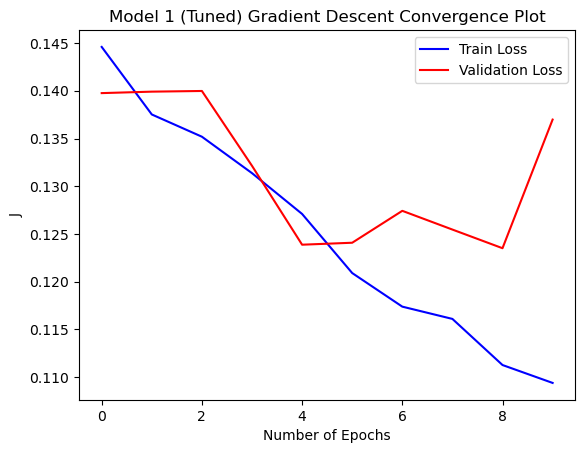

In [99]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 1 (Tuned) Gradient Descent Convergence Plot')
plt.show()

Actual: Sushi 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Dimsum


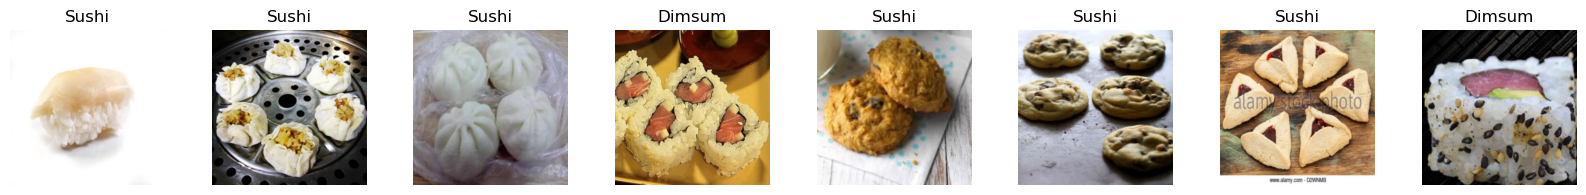

In [103]:
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
images, labels = next(iter(test_loader))              
images = images.to(device)
labels = labels.to(device)

outputs = model_tuned(images)
_, predicted = torch.max(outputs, dim = 1)                

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [104]:
test_dense(model_tuned)

Results of Model 1 on the Test Images: 
Accuracy: 46.833333333333336%
Precision: 0.4444444444444444
Recall: 0.6666666666666666
F1-score: 0.5 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         5
           2       0.33      1.00      0.50         1

    accuracy                           0.75         8
   macro avg       0.44      0.67      0.50         8
weighted avg       0.67      0.75      0.69         8



c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

## Question 2: CNN

### Building the Model

In [105]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # 16 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 x 64 x 64

            nn.Conv2d(in_channels=16, out_channels=40, kernel_size=3, stride=2, padding=1), # 40 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 40 x 16 x 16

            nn.Flatten(),
            nn.Linear(40*16*16, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU(),
            nn.Linear(10,3),
            nn.LogSoftmax(dim=1)

        )

    def forward(self, x):
        return self.network(x)

In [106]:
model2 = CNNModel()
model2=model2.to(device)
print(model2)

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=10240, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=3, bias=True)
    (12): LogSoftmax(dim=1)
  )
)


In [108]:
criteria = nn.NLLLoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
train_history = []                                         
validation_history = []

# Training Loop
model2.train()                                              
                                                            
for epoch in range(10):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(1, -1)

        optimizer.zero_grad()
        outputs = model2(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model2(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')

Epoch [1] --> Training Loss: 0.022936750029265467 | Validation Loss: 0.10644950746248166
Epoch [2] --> Training Loss: 0.01326978718318666 | Validation Loss: 0.09834022562329968
Epoch [3] --> Training Loss: 0.010048109266062966 | Validation Loss: 0.10799543143715709
Epoch [4] --> Training Loss: 0.004287281146009465 | Validation Loss: 0.10822197748891388
Epoch [5] --> Training Loss: 0.008859508632158395 | Validation Loss: 0.10953153893196334
Epoch [6] --> Training Loss: 0.001890709288238415 | Validation Loss: 0.1253400600688959
Epoch [7] --> Training Loss: 0.000470000484323868 | Validation Loss: 0.1350394379789941
Epoch [8] --> Training Loss: 0.00018702698178786807 | Validation Loss: 0.13892615889169974
Epoch [9] --> Training Loss: 0.00011437772517537168 | Validation Loss: 0.14454109751570893
Epoch [10] --> Training Loss: 8.296496130520204e-05 | Validation Loss: 0.15134240513541347

Finished Training


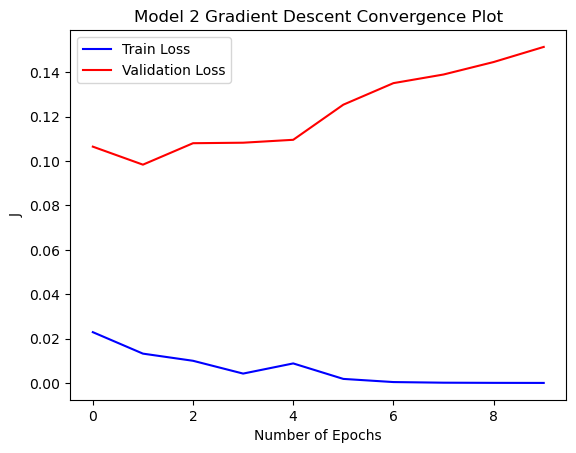

In [109]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 2 Gradient Descent Convergence Plot')
plt.show()

### Model Performance

Actual: Sushi 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Dimsum
Actual: Sushi 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi


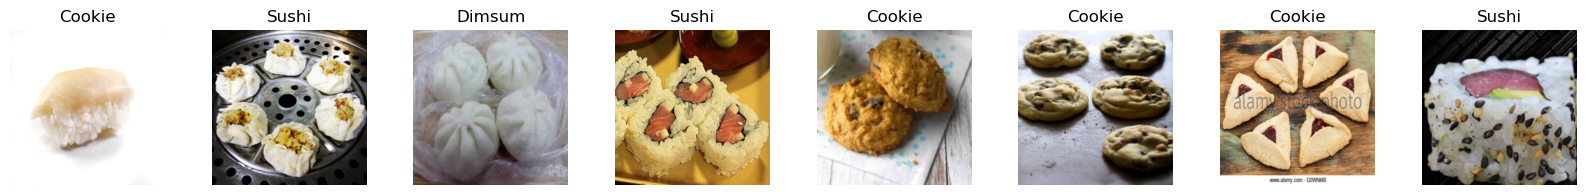

In [111]:
images, labels = next(iter(test_loader))              
images = images.to(device)
labels = labels.to(device)

outputs = model2(images)
_, predicted = torch.max(outputs, dim = 1)                

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [113]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

print('Results of Model 2 on the Test Images: ')        
print(f'Accuracy: {100 * correct / total}%')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1} \n")
print(classification_report(labels.cpu(), predicted.cpu()))

Results of Model 2 on the Test Images: 
Accuracy: 78.66666666666667%
Precision: 0.5555555555555555
Recall: 0.6666666666666666
F1-score: 0.6 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.56      0.67      0.60         8
weighted avg       0.79      0.88      0.82         8



c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ronyf\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

### Hyperparameter Tuning with Ray Tune

In [114]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
class CNNTune(nn.Module):
    def __init__(self,  outch1=16, outch2 = 40, l1=32, l2=10):
        super(CNNTune, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=outch1, kernel_size=3, stride=2, padding=1), # outch1 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # outch1 x 64 x 64

            nn.Conv2d(in_channels=outch1, out_channels=outch2, kernel_size=3, stride=2, padding=1), # outch2 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # outch2 x 16 x 16

            nn.Flatten(),
            nn.Linear(outch2*16*16, l1),
            nn.ReLU(),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Linear(l2,3),
            nn.LogSoftmax(dim=1)

        )

    def forward(self, x):
        return self.network(x)

In [120]:
def train_cnn(config):
    cnntune = CNNTune(config["outch1"], config["outch2"], config["l1"], config["l2"])
    cnntune.to(device)
    train_history = []
    validation_history = []

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(cnntune.parameters(), lr=config["lr"])
    checkpoint = train.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        cnntune.load_state_dict(checkpoint_state["cnntune_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = cnntune(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnntune(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                torch.save(
                    cnntune.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            train.report({"accuracy": (100 * correct / total)}, checkpoint=checkpoint)

In [121]:
def test_cnn(cnntune):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnntune(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

    print('Results of Model 2 (Tuned) on the Test Images: ')        
    print(f'Accuracy: {100 * correct / total}%')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1} \n")
    print(classification_report(labels.cpu(), predicted.cpu()))

In [126]:
config = {
    "outch1": tune.choice([2 * i for i in range(21)]),
    "outch2": tune.choice([2 * i for i in range(21)]),
    "l1": tune.choice([2 ** i for i in range(6)]),
    "l2": tune.choice([2 ** i for i in range(6)]),
    "lr": tune.loguniform(1e-4, 1e-1)
}

tuner = tune.Tuner(
  train_cnn,
  tune_config=tune.TuneConfig(
      num_samples=10,
      scheduler=ASHAScheduler(metric="accuracy", mode="max"),
  ),
  param_space=config,
)

result = tuner.fit()

(train_cnn pid=20112) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_cnn pid=20112)   warnings.warn(
(train_cnn pid=17320) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_cnn pid=17320)   warnings.warn(
(train_cnn pid=14628) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_cnn pid=14628)   warnings.warn(
(train_cnn pid=24360) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images [repeated 2x across cluster]
(train_cnn pid=24360)   warnings.warn( [repeated 2x across cluster]
(train_cnn pid=13380) c:\Users\ronyf\anaconda3\Lib\sit

### Performance Using Best Results from Ray Tune

In [127]:
best_result = result.get_best_result("accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

cnn_tuned = CNNTune(best_result.config['outch1'], best_result.config['outch2'], best_result.config['l1'], best_result.config['l2'])
cnn_tuned = cnn_tuned.to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criteria = nn.NLLLoss()
optimizer = optim.Adam(cnn_tuned.parameters(), lr = best_result.config['lr'])
train_history = []                                         
validation_history = []

# Training Loop
cnn_tuned.train()                                              
                                                            
for epoch in range(10):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(inputs.shape[0], -1)

        optimizer.zero_grad()
        outputs = cnn_tuned(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = cnn_tuned(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')


c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.01948619736565484 | Validation Loss: 0.017346888879934946
Epoch [2] --> Training Loss: 0.015843502978483835 | Validation Loss: 0.016428589522838592
Epoch [3] --> Training Loss: 0.014819670915603638 | Validation Loss: 0.017818639477094014
Epoch [4] --> Training Loss: 0.013692925605509016 | Validation Loss: 0.016007918814818063
Epoch [5] --> Training Loss: 0.012114077392551634 | Validation Loss: 0.014280562897523245
Epoch [6] --> Training Loss: 0.010455884039402008 | Validation Loss: 0.015431274871031443
Epoch [7] --> Training Loss: 0.009292052040497462 | Validation Loss: 0.017151733537515004
Epoch [8] --> Training Loss: 0.007442018538713455 | Validation Loss: 0.01822102556626002
Epoch [9] --> Training Loss: 0.0059793411857552 | Validation Loss: 0.021090501844882967
Epoch [10] --> Training Loss: 0.0056243317822615305 | Validation Loss: 0.021236154437065124

Finished Training


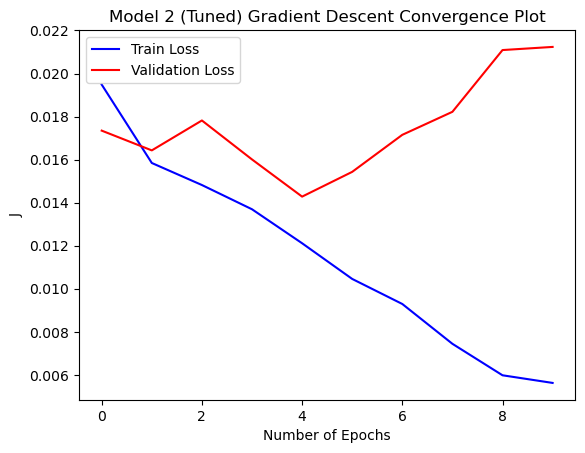

In [128]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 2 (Tuned) Gradient Descent Convergence Plot')
plt.show()

Actual: Sushi 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Dimsum
Actual: Sushi 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi


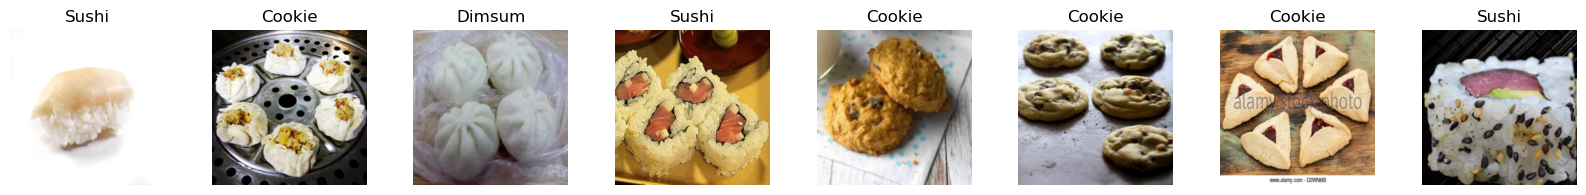

In [129]:
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)
images, labels = next(iter(test_loader))              
images = images.to(device)
labels = labels.to(device)

outputs = cnn_tuned(images)
_, predicted = torch.max(outputs, dim = 1)                

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [130]:
test_cnn(cnn_tuned)

Results of Model 2 (Tuned) on the Test Images: 
Accuracy: 64.83333333333333%
Precision: 0.6018518518518519
Recall: 0.6111111111111112
F1-score: 0.5555555555555556 

              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       1.00      0.50      0.67        14
           2       0.25      0.50      0.33         4

    accuracy                           0.58        24
   macro avg       0.60      0.61      0.56        24
weighted avg       0.76      0.58      0.61        24



## Question 3: ImageNet

### Building the Model - Frozen

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.base_model = models.resnet50(pretrained=True)
    
        dummy_input = torch.randn(1, 3, 256, 256)  
        with torch.no_grad():
            features = self.base_model(dummy_input)
        num_features = features.shape[1]

        self.head = nn.Linear(num_features, 3)
        self.prob = nn.LogSoftmax(dim=1)

        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        x = self.head(x)
        x = self.prob(x)
        return x

In [5]:
model3 = ResNet()
model3 = model3.to(device)
print(model3)

c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [6]:
criteria = nn.NLLLoss()
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
train_history = []                                         
validation_history = []

# Training Loop
model3.train()                                              
                                                            
for epoch in range(10):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(1, -1)

        optimizer.zero_grad()
        outputs = model3(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model3(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')

c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.00772484695745839 | Validation Loss: 0.004932498261332512
Epoch [2] --> Training Loss: 0.0034299447449545064 | Validation Loss: 0.003925907388329506
Epoch [3] --> Training Loss: 0.0031493307443128692 | Validation Loss: 0.003720101366440455
Epoch [4] --> Training Loss: 0.0020981340524223115 | Validation Loss: 0.003146703777213891
Epoch [5] --> Training Loss: 0.002130942828953266 | Validation Loss: 0.0031675075367093085
Epoch [6] --> Training Loss: 0.0019068092438909742 | Validation Loss: 0.003047496813038985
Epoch [7] --> Training Loss: 0.0019063784430424372 | Validation Loss: 0.002943844050168991
Epoch [8] --> Training Loss: 0.0017564242503916223 | Validation Loss: 0.0035348089784383776
Epoch [9] --> Training Loss: 0.0014922541110879844 | Validation Loss: 0.0032544624308745067
Epoch [10] --> Training Loss: 0.0016156594331065814 | Validation Loss: 0.0029433305809895196

Finished Training


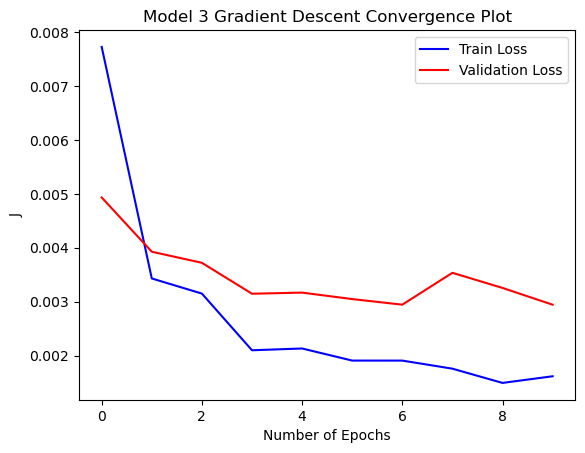

In [7]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 3 Gradient Descent Convergence Plot')
plt.show()

### Model Performance - Frozen

Actual: Dimsum 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Dimsum
Actual: Dimsum 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Dimsum


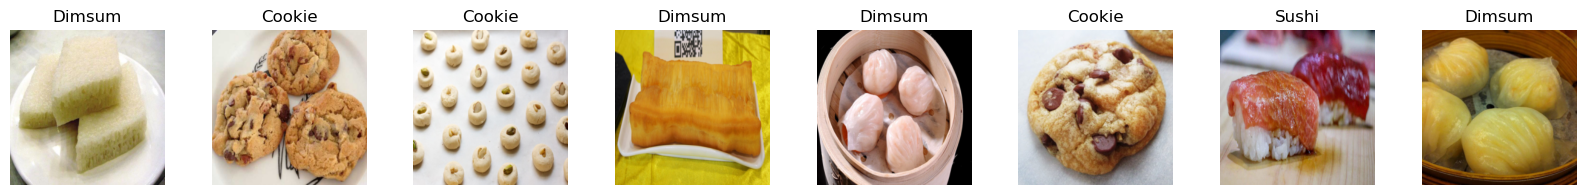

In [10]:
images, labels = next(iter(test_loader))              
images = images.to(device)
labels = labels.to(device)

outputs = model3(images)
_, predicted = torch.max(outputs, dim = 1)                

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

print('Results of Model 3 on the Test Images: ')        
print(f'Accuracy: {100 * correct / total}%')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1} \n")
print(classification_report(labels.cpu(), predicted.cpu()))

Results of Model 3 on the Test Images: 
Accuracy: 95.0%
Precision: 1.0
Recall: 1.0
F1-score: 1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        10

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



### Hyperparameter Tuning with Ray Tune - Frozen

The parameters we chose to tune are:
- Batch size of the images
- Learning rate

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ResNetTune(nn.Module):
    def __init__(self):
        super(ResNetTune, self).__init__()

        self.base_model = models.resnet50(pretrained=True)
    
        dummy_input = torch.randn(1, 3, 256, 256)  
        with torch.no_grad():
            features = self.base_model(dummy_input)
        num_features = features.shape[1]

        self.head = nn.Linear(num_features, 3)
        self.prob = nn.LogSoftmax(dim=1)

        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        x = self.head(x)
        x = self.prob(x)
        return x

In [5]:
def train_resnet(config):
    resnetTune = ResNetTune()
    resnetTune = resnetTune.to(device)
    train_history = []
    validation_history = []

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(resnetTune.parameters(), lr=config["lr"])
    checkpoint = train.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        resnetTune.load_state_dict(checkpoint_state["resnetTune_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainloader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(start_epoch, 2):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = resnetTune(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnetTune(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                torch.save(
                    resnetTune.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            train.report({"accuracy": (100 * correct / total)}, checkpoint=checkpoint)

In [6]:
def test_resnet(resnetTune):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnetTune(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

    print('Results of Model 3 on the Test Images: ')        
    print(f'Accuracy: {100 * correct / total}%')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1} \n")
    print(classification_report(labels.cpu(), predicted.cpu()))

In [7]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16, 32, 64])
}

tuner = tune.Tuner(
  train_resnet,
  tune_config=tune.TuneConfig(
      num_samples=2,
      scheduler=ASHAScheduler(metric="accuracy", mode="max"),
  ),
  param_space=config,
)

result = tuner.fit()

(train_resnet pid=20012) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_resnet pid=20012)   warnings.warn(
(train_resnet pid=20012) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(train_resnet pid=20012)   warnings.warn(msg)
(train_resnet pid=19788) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_resnet pid=19788) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\model

### Performance Using Best Results from Ray Tune - Frozen

In [8]:
best_result = result.get_best_result("accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model_tuned = ResNetTune()
model_tuned = model_tuned.to(device)

train_loader = DataLoader(train_dataset, batch_size=best_result.config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

criteria = nn.NLLLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr = best_result.config['lr'])
train_history = []
validation_history = []

# Training Loop
model_tuned.train()

for epoch in range(10):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(inputs.shape[0], -1)

        optimizer.zero_grad()
        outputs = model_tuned(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model_tuned(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')


c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.053870426647804885 | Validation Loss: 0.04940266007712732
Epoch [2] --> Training Loss: 0.04853303258177928 | Validation Loss: 0.04372888180000397
Epoch [3] --> Training Loss: 0.041968844043181484 | Validation Loss: 0.042903091167099776
Epoch [4] --> Training Loss: 0.04123672551268505 | Validation Loss: 0.06493935937449957
Epoch [5] --> Training Loss: 0.04449074549678092 | Validation Loss: 0.04702681496739387
Epoch [6] --> Training Loss: 0.038349465491482986 | Validation Loss: 0.0468115871027112
Epoch [7] --> Training Loss: 0.03500630537687458 | Validation Loss: 0.050627827982631664
Epoch [8] --> Training Loss: 0.04908538358429925 | Validation Loss: 0.045641140556156944
Epoch [9] --> Training Loss: 0.04435511612541935 | Validation Loss: 0.07437907457516606
Epoch [10] --> Training Loss: 0.03839591650800786 | Validation Loss: 0.05718579080275958

Finished Training


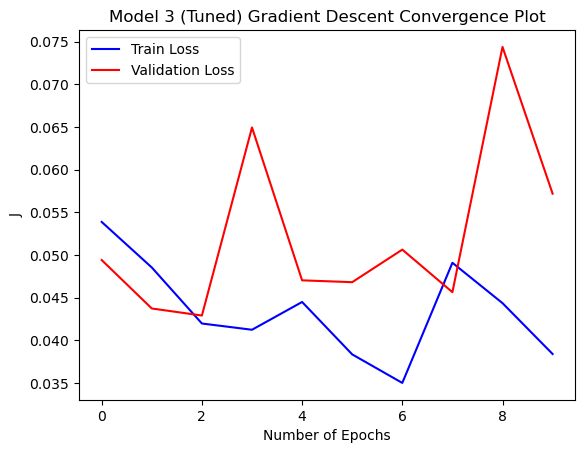

In [9]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 3 (Tuned) Gradient Descent Convergence Plot')
plt.show()

Actual: Sushi 		 Predicted: Dimsum
Actual: Sushi 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi


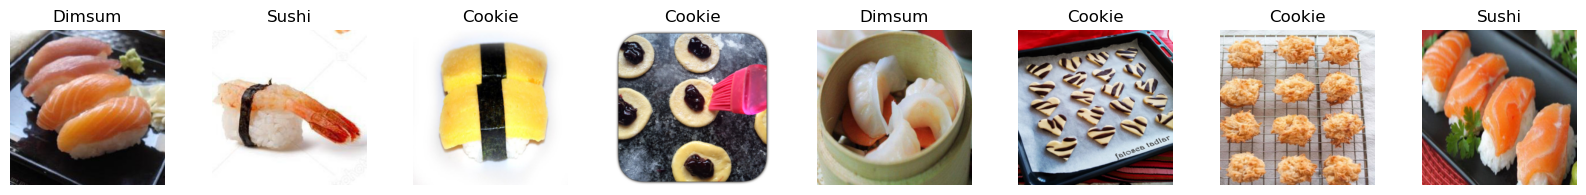

In [13]:
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

outputs = model_tuned(images)
_, predicted = torch.max(outputs, dim = 1)

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [14]:
test_resnet(model_tuned)

Results of Model 3 on the Test Images: 
Accuracy: 89.0%
Precision: 0.75
Recall: 0.8333333333333334
F1-score: 0.7301587301587301 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         4
           2       0.50      1.00      0.67         1

    accuracy                           0.75         8
   macro avg       0.75      0.83      0.73         8
weighted avg       0.84      0.75      0.74         8



### Building the Model - Unfrozen

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ResNetF(nn.Module):
    def __init__(self):
        super(ResNetF, self).__init__()

        self.base_model = models.resnet50(pretrained=True)
    
        dummy_input = torch.randn(1, 3, 256, 256)  
        with torch.no_grad():
            features = self.base_model(dummy_input)
        num_features = features.shape[1]

        self.head = nn.Linear(num_features, 3)
        self.prob = nn.LogSoftmax(dim=1)

        for param in self.base_model.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.base_model(x)
        x = self.head(x)
        x = self.prob(x)
        return x

In [17]:
model4 = ResNetF().to(device)
criteria = nn.NLLLoss()
optimizer = optim.Adam(model4.parameters(), lr = 0.001)
train_history = []                                         
validation_history = []

# Training Loop
model4.train()                                              
                                                            
for epoch in range(5):                                    
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(1, -1)

        optimizer.zero_grad()
        outputs = model4(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model4(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')

c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.13555595599942738 | Validation Loss: 0.09444595515727996
Epoch [2] --> Training Loss: 0.09653297179275089 | Validation Loss: 0.0891260814666748
Epoch [3] --> Training Loss: 0.08637318681097693 | Validation Loss: 0.08770926792174577
Epoch [4] --> Training Loss: 0.07595722313556406 | Validation Loss: 0.08684670935074489
Epoch [5] --> Training Loss: 0.07124250353210503 | Validation Loss: 0.0814747821042935

Finished Training


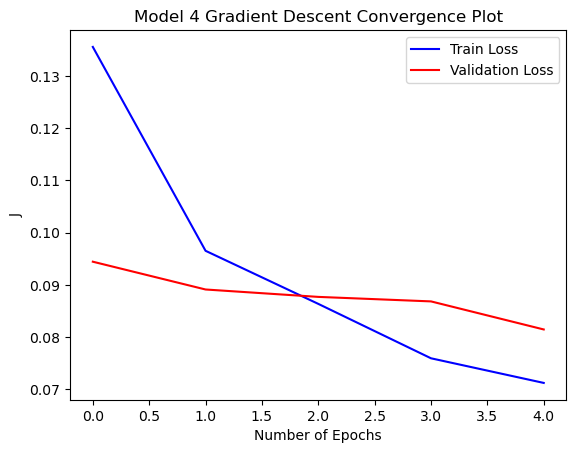

In [18]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 4 Gradient Descent Convergence Plot')
plt.show()

### Model Performance - Unfrozen

Actual: Sushi 		 Predicted: Dimsum
Actual: Sushi 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Cookie
Actual: Dimsum 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Cookie
Actual: Cookie 		 Predicted: Cookie
Actual: Sushi 		 Predicted: Sushi


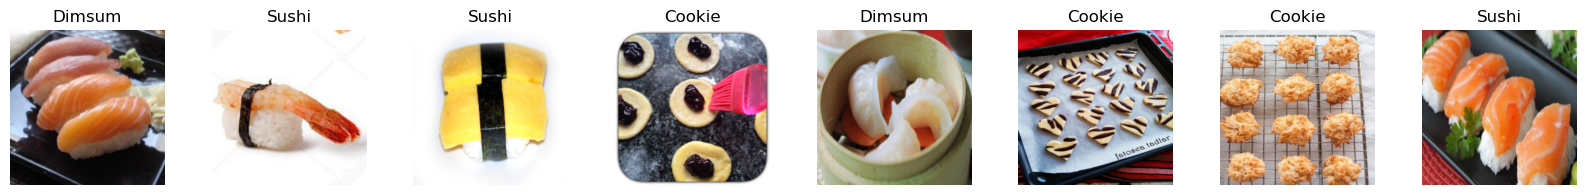

In [19]:
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

outputs = model4(images)
_, predicted = torch.max(outputs, dim = 1)

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

print('Results of Model 3 on the Test Images: ')        
print(f'Accuracy: {100 * correct / total}%')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1} \n")
print(classification_report(labels.cpu(), predicted.cpu()))

Results of Model 3 on the Test Images: 
Accuracy: 75.33333333333333%
Precision: 0.5833333333333334
Recall: 0.5
F1-score: 0.5079365079365079 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         1

    accuracy                           0.62         8
   macro avg       0.58      0.50      0.51         8
weighted avg       0.78      0.62      0.65         8



### Hyperparameter Tuning with Ray Tune - Unfrozen

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ResNetTuneF(nn.Module):
    def __init__(self):
        super(ResNetTuneF, self).__init__()

        self.base_model = models.resnet50(pretrained=True)
    
        dummy_input = torch.randn(1, 3, 256, 256)  
        with torch.no_grad():
            features = self.base_model(dummy_input)
        num_features = features.shape[1]

        self.head = nn.Linear(num_features, 3)
        self.prob = nn.LogSoftmax(dim=1)

        for param in self.base_model.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.base_model(x)
        x = self.head(x)
        x = self.prob(x)
        return x

In [22]:
def train_resnetf(config):
    resnetTune = ResNetTuneF()
    resnetTune = resnetTune.to(device)
    train_history = []
    validation_history = []

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(resnetTune.parameters(), lr=config["lr"])
    checkpoint = train.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        resnetTune.load_state_dict(checkpoint_state["resnetTune_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainloader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(start_epoch, 2):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = resnetTune(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnetTune(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                torch.save(
                    resnetTune.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            train.report({"accuracy": (100 * correct / total)}, checkpoint=checkpoint)

In [23]:
def test_resnetf(resnetTune):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnetTune(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    precision = precision_score(labels.cpu(), predicted.cpu(), average='macro')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='macro')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

    print('Results of Model 3 on the Test Images: ')        
    print(f'Accuracy: {100 * correct / total}%')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1} \n")
    print(classification_report(labels.cpu(), predicted.cpu()))

In [42]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16, 32, 64])
}

tuner = tune.Tuner(
  train_resnetf,
  tune_config=tune.TuneConfig(
      num_samples=2,
      scheduler=ASHAScheduler(metric="accuracy", mode="max"),
  ),
  param_space=config,
)

result = tuner.fit()

(train_resnetf pid=23176) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_resnetf pid=23176)   warnings.warn(
(train_resnetf pid=23176) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(train_resnetf pid=23176)   warnings.warn(msg)
(train_resnetf pid=23176) c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
(train_resnetf pid=20596) c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision

### Performance Using Best Results from Ray Tune - Unfrozen

In [44]:
best_result = result.get_best_result("accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model_tuned = ResNetTuneF()
model_tuned = model_tuned.to(device)

train_loader = DataLoader(train_dataset, batch_size=best_result.config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

criteria = nn.NLLLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr = best_result.config['lr'])
train_history = []
validation_history = []

# Training Loop
model_tuned.train()

for epoch in range(5):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = inputs.reshape(inputs.shape[0], -1)

        optimizer.zero_grad()
        outputs = model_tuned(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(1, -1)
            outputs = model_tuned(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(train_dataset)} | Validation Loss: {val_loss / len(val_dataset)}')
    train_history += [train_loss / len(train_dataset)]
    validation_history += [val_loss / len(val_dataset)]
print('\nFinished Training')


c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ronyf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ronyf\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1] --> Training Loss: 0.19950033992528915 | Validation Loss: 0.12362540870904923
Epoch [2] --> Training Loss: 0.12349147958887947 | Validation Loss: 0.143973511805137
Epoch [3] --> Training Loss: 0.11349980683790313 | Validation Loss: 0.12377188667654991
Epoch [4] --> Training Loss: 0.10541074832280477 | Validation Loss: 0.10043243169784546
Epoch [5] --> Training Loss: 0.09479773517284129 | Validation Loss: 0.09836320000390211

Finished Training


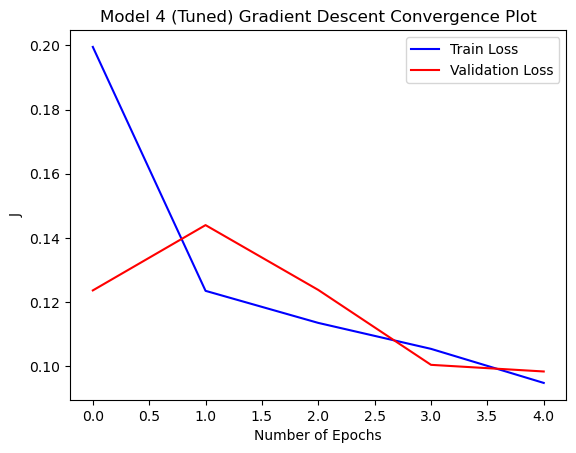

In [47]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 4 (Tuned) Gradient Descent Convergence Plot')
plt.show()

Actual: Sushi 		 Predicted: Dimsum
Actual: Sushi 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Sushi
Actual: Dimsum 		 Predicted: Dimsum
Actual: Cookie 		 Predicted: Sushi
Actual: Cookie 		 Predicted: Sushi
Actual: Sushi 		 Predicted: Sushi


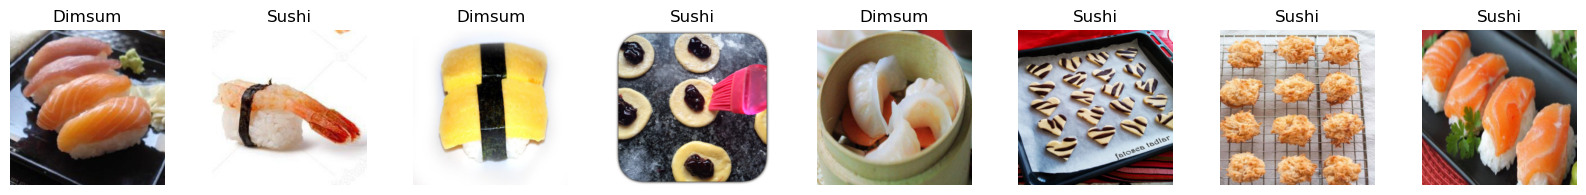

In [45]:
test_loader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

outputs = model_tuned(images)
_, predicted = torch.max(outputs, dim = 1)

idx_to_class = {value: key for key, value in train_dataset.dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [46]:
test_resnetf(model_tuned)

Results of Model 3 on the Test Images: 
Accuracy: 63.0%
Precision: 0.8333333333333334
Recall: 0.9166666666666666
F1-score: 0.8412698412698413 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.75      0.86         4
           2       0.50      1.00      0.67         1

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.84         8
weighted avg       0.94      0.88      0.89         8

